In [245]:
import os
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import cvxpy as cp
from tqdm.notebook import tqdm
from regimeaware.routines import cfg
from regimeaware.core import utils

rebalance_dts = pd.date_range(start=cfg.bt_start_dt, end=cfg.bt_end_dt, freq=cfg.rebalance_freq)

# Data
rt_ff = pd.read_pickle(f'{cfg.data_fldr}/ff.pkl')[cfg.factor_set]
crsp = pd.read_pickle(f'{cfg.data_fldr}/crsp.pkl')
rt = pd.pivot_table(crsp[['excess_ret']], index='date', columns='permno', values='excess_ret')

# Load cached factor estimates
factor_covars = pd.read_pickle(f'{cfg.data_fldr}/moments/factor_covars.pkl')
factor_means = pd.read_pickle(f'{cfg.data_fldr}/moments/factor_means.pkl')
factor_loadings = pd.read_pickle(f'{cfg.data_fldr}/exposures/forecasted_betas.pkl')
factor_variance = pd.read_pickle(f'{cfg.data_fldr}/exposures/var.pkl')

# Reference market cap weights
mktcap = crsp['mktcap'].copy()
ref_wts = mktcap.groupby('permno').shift(1).reindex(factor_loadings.index.droplevel('factor').unique())
ref_wts = ref_wts.div(ref_wts.groupby('date').sum())

bm = ref_wts.groupby('id').shift(1).mul(crsp['excess_ret'].reindex(ref_wts.index)).groupby('date').sum().add(1).cumprod()

$$
\begin{equation}
\begin{aligned}
& \underset{w}{\text{argmin}} & & \gamma \left( w^{T} F^{T} \Sigma_{f} F w + w^{T} E w \right) - w^{T} \mu_{f} \\
& \text{s.t.} & & (w - b)^{T} \Sigma (w - b) \leq \bar{\sigma}^{2} \\
& & & \sum_{i=1}^{N} w_i = 1 \\
& & &  w_i \geq 0 \; ; \; \forall \; i =1, \ldots, N \\
\end{aligned}
\end{equation}
$$

In [289]:
collect_w = {}

for g in [.5, 1, 2]:
    for t in [.01, .025, .05, .1]:
        for dt in tqdm(rebalance_dts, desc=f'gamma: {g}, te budget: {t * 100}%'):
            # Data handling
            sec_ids = ref_wts.xs(dt).index # This has to be changes to a cached 'is_tradable' flag
            mu_f = factor_means.xs(dt)[cfg.factor_set].values.reshape(-1, 1)
            mu_f_const = np.concatenate([np.array([[1]]), mu_f], axis=0)  # Adding back the constant
            Sigma_f = factor_covars.xs(dt).loc[cfg.factor_set, cfg.factor_set].values
            F = utils.unpack_betas(factor_loadings.xs(dt)).reindex(sec_ids).values.T
            E = np.diag(factor_variance.xs(dt).reindex(sec_ids))
            b = mktcap.xs(dt).reindex(sec_ids).values.reshape(-1, 1)
            b = np.divide(b, b.sum())

            # Optimization problem
            tev_budget = cp.Parameter(nonneg=True)
            gamma = cp.Parameter(nonneg=True)

            m, n = F.shape
            w = cp.Variable((n, 1))
            f = cp.Variable((m, 1))

            Sigma_f_const = np.zeros((m, m))
            Sigma_f_const[1:, 1:] = Sigma_f

            tracking_error = cp.quad_form(F @ (w - b), Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ (w - b))
            port_risk = cp.quad_form(f, Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ w)  # TODO: test with quadform
            port_return = mu_f_const.T @ f

            constraints = [
                cp.sum(w) == 1,
                f == F @ w,
                w >= 0,
                tracking_error <= tev_budget 
            ]

            gamma.value = g
            tev_budget.value = (t / 12) ** 2 

            prob = cp.Problem(cp.Maximize(port_return - gamma * port_risk), constraints)
            prob.solve(verbose=False)
            collect_w[(t, g, dt)] = pd.Series(w.value.flatten(), index=sec_ids)


gamma: 0.5, te budget: 1.0%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

gamma: 0.5, te budget: 2.5%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

gamma: 0.5, te budget: 5.0%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

gamma: 0.5, te budget: 10.0%:   0%|          | 0/241 [00:00<?, ?it/s]

gamma: 1, te budget: 1.0%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

gamma: 1, te budget: 2.5%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

gamma: 1, te budget: 5.0%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

gamma: 1, te budget: 10.0%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


gamma: 2, te budget: 1.0%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

gamma: 2, te budget: 2.5%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

gamma: 2, te budget: 5.0%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

gamma: 2, te budget: 10.0%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

gamma: 3, te budget: 1.0%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

SolverError: Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.

In [349]:
wts = pd.DataFrame.from_dict(collect_w, orient='index').fillna(0)

collect_bt = {}
for g in [.5, 1, 2]:
    for t in [.01, .025, .05, .1]:
        wt = wts.xs(t).xs(g)
        collect_bt[(g, t)] = wt.shift(1).mul(rt).dropna(how='all').sum(axis=1)

bt = pd.DataFrame.from_dict(collect_bt)
bt = bt.reindex(bm.index).fillna(0)
bt.columns = [f'Gamma: {x}\nTE Budget: {y * 100}' for x,y in bt.columns]

<Axes: xlabel='date'>

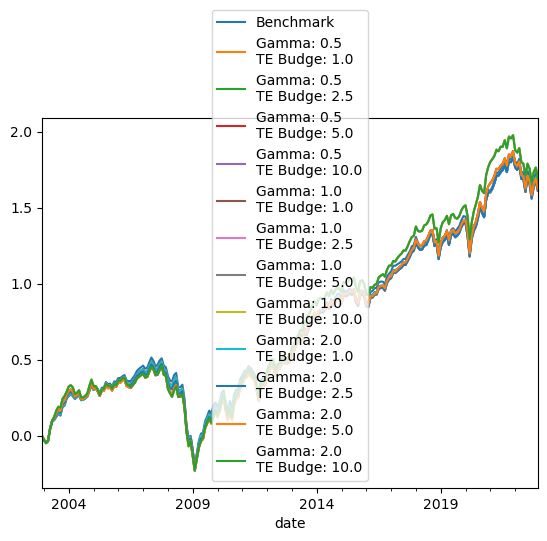

In [359]:
df = bm.to_frame(name='Benchmark').join(bt.add(1).cumprod())
df.apply(np.log).plot()

In [375]:
tracking = df.sub(df['Benchmark'], axis=0).drop('Benchmark', axis=1)
tracking.mean().div(tracking.std()).mul(np.sqrt(12)).sort_values()

Gamma: 2.0\nTE Budge: 1.0    -4.312830
Gamma: 2.0\nTE Budge: 2.5    -4.264124
Gamma: 1.0\nTE Budge: 2.5    -4.242558
Gamma: 0.5\nTE Budge: 2.5    -4.238912
Gamma: 1.0\nTE Budge: 1.0    -4.149241
Gamma: 0.5\nTE Budge: 1.0    -4.129430
Gamma: 2.0\nTE Budge: 5.0    -2.084688
Gamma: 1.0\nTE Budge: 5.0    -2.040000
Gamma: 0.5\nTE Budge: 5.0    -2.022960
Gamma: 2.0\nTE Budge: 10.0    1.965282
Gamma: 0.5\nTE Budge: 10.0    1.974374
Gamma: 1.0\nTE Budge: 10.0    1.975433
dtype: float64

Obs
- Higher TEV-Budget leads to better IR
- Higher risk aversion leads to lower IR? 